In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install segmentation-models-pytorch albumentations --upgrade

import segmentation_models_pytorch as smp #has pre-trained models for semantic segmentation
import albumentations as A #for image augmentation
from albumentations.pytorch import ToTensorV2 #Numpy format to PyTorch tensor format

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.6/290.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 24.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8905b78796238acfffbb1e4095de5ce0162452deb773b7c621bc8bdbf15bc855
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=eafe2779865d02c540d2289ccb771e796047202b9bc20d

In [2]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import time
import copy
import segmentation_models_pytorch as smp
from torch.nn import functional as F


ImageFile.LOAD_TRUNCATED_IMAGES = True #So that truncated Images dont crash the system

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class CustomSegmentationDataset(Dataset):
    def __init__(self, root, transformations=None):
        self.im_paths = sorted(glob(f"{root}/image/*.png"))
        self.gt_paths = sorted(glob(f"{root}/image/*.png"))
        self.transformations = transformations
        self.n_cls = 2 #As we have binary Classification

    def __len__(self): #No of images in dataset #Reading an image
        return len(self.im_paths)

    def read_im(self, path, gray=None): #Reading an image
        return cv2.imread(path, cv2.IMREAD_COLOR) if not gray else cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    def get_im_gt(self, im_path, gt_path): #Load image in grayscale if there is condition
        return self.read_im(im_path), self.read_im(gt_path, gray = True)

    def __getitem__(self, idx): #Get the image and mask for the given index
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        if self.transformations:
            im, gt = self.apply_transformations(im, gt)
        return im, (gt>128).int() #Converts pixels values greater than 128 to 1 and less than 128 to 0)

    def apply_transformations(self, im, gt):
        transformed = self.transformations(image = im, mask = gt)
        return transformed['image'], transformed['mask']

In [ ]:
#WE Will split the dataset into multiple clients and then return their dataloaders
def get_client_dataloaders(root, transformations, bs, num_clients = 4, ns = 4): #bs = batch_size, ns = num_workers(default = 4)
    full_ds = CustomSegmentationDataset(root = root, transformations = transformations)

    client_sizes = [len(full_ds)//num_clients] * num_clients
    client_sizes[-1] += len(full_ds) % num_clients #leftover data is given to the last client
    client_datasets = random_split(full_ds, client_sizes)

    client_dataloaders = []
    for ds in client_datasets:
        train_size = int(0.9 * len(ds))
        val_size = len(ds) - train_size
        train_ds, val_ds = random_split(ds, [train_size, val_size])

        train_dl = DataLoader(train_ds, batch_size = bs, shuffle = True, num_workers = ns)
        val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, num_workers = ns)

        client_dataloaders.append((train_dl, val_dl))

    return client_dataloaders, full_ds.n_cls

In [ ]:
class Metrics():
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim = 1), dim = 1), gt
        self.loss_fn = loss_fn
        self.eps = eps
        self.n_cls = n_cls
        self.pred_ = pred

    def to_contiguous(self,inp):
        return inp.contiguous().view(-1)

    def PA(self): #Pixel Accuracy
        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        return float(match.sum())/float(match.numel())

    def mIoU(self):
        with torch.no_grad():
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)
            iou_per_class = []

            for c in range(self.n_cls):
                match_pred = pred==c
                match_gt = gt==c

                if match_gt.long().sum().item() == 0:
                    iou_per_class.append(np.nan)
                else:
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()
                    iou = (intersect + self.eps)/(union + self.eps)
                    iou_per_class.append(iou)
            return np.nanmean(iou_per_class)
                    
    def loss(self):
        return self.loss_fn((self.pred_), self.gt.long())

In [ ]:
# We will train client data on client model
def client_update(client_model, optimizer, train_loader, device, epochs = 1):
    client_model.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.cross_entropy(output, target.squeeze(1).long())
            loss.backward()
            optimizer.step()
    return client_model.state_dict(), len(train_loader.dataset)


In [ ]:
def server_aggregate(global_model, client_weights, client_sizes):
    global_dict = global_model.state_dict()
    total_size = sum(client_sizes)

    for key in global_dict:
        if global_dict[key].dtype == torch.long:
            global_dict[key] = client_weights[0][key].clone()

        else:
            global_dict[key] = torch.zeros_like(global_dict[key]) #Initialize with zeros 
            for i in range(len(client_weights)):
                global_dict[key] += client_weights[i][key] * (client_sizes[i]/total_size)

    global_model.load_state_dict(global_dict) #load updated weights to global model
    return global_model

In [41]:
def evaluate(model, data_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss, total_pa, total_iou = 0.0, 0.0, 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            met = Metrics(output, target, loss_fn)
            total_loss += met.loss().item()
            total_pa += met.PA()
            total_iou += met.mIoU()

    avg_loss = total_loss / len(data_loader)
    avg_pa = total_pa / len(data_loader)
    avg_iou = total_iou / len(data_loader)

    return avg_loss, avg_pa, avg_iou

In [ ]:
def federated_training(num_rounds, num_clients, client_dataloaders, device, save_prefix="federated_lung"):
    # Initialize global model
    global_model = smp.DeepLabV3Plus(classes=n_cls).to(device)
    best_loss = float('inf')
    os.makedirs("saved_models", exist_ok=True)
    
    # History tracking
    history = {
        'round': [],
        'train_loss': [],
        'train_pa': [],
        'train_iou': [],
        'val_loss': [],
        'val_pa': [],
        'val_iou': []
    }
    
    for round in range(1, num_rounds + 1):
        print(f"\nRound {round}/{num_rounds}")
        client_weights = []
        client_sizes = []
        
        # Train each client
        for client_id in range(num_clients):
            print(f"Training client {client_id + 1}/{num_clients}")
            train_loader, val_loader = client_dataloaders[client_id]
            
            # Create client model with current global weights
            client_model = smp.DeepLabV3Plus(classes=n_cls).to(device)
            client_model.load_state_dict(global_model.state_dict())
            
            optimizer = optim.Adam(client_model.parameters(), lr=3e-4)
            
            # Train client
            weights, size = client_update(client_model, optimizer, train_loader, device)
            client_weights.append(weights)
            client_sizes.append(size)
            
            # Evaluate client (optional)
            client_loss, client_pa, client_iou = evaluate(client_model, val_loader, device)
            print(f"Client {client_id + 1} - Loss: {client_loss:.4f}, PA: {client_pa:.4f}, IoU: {client_iou:.4f}")
        
        # Aggregate client models
        global_model = server_aggregate(global_model, client_weights, client_sizes)
        
        # Evaluate global model on all validation data
        round_train_loss, round_train_pa, round_train_iou = 0.0, 0.0, 0.0
        round_val_loss, round_val_pa, round_val_iou = 0.0, 0.0, 0.0
        count = 0
        
        for train_loader, val_loader in client_dataloaders:
            train_loss, train_pa, train_iou = evaluate(global_model, train_loader, device)
            val_loss, val_pa, val_iou = evaluate(global_model, val_loader, device)
            
            round_train_loss += train_loss
            round_train_pa += train_pa
            round_train_iou += train_iou
            
            round_val_loss += val_loss
            round_val_pa += val_pa
            round_val_iou += val_iou
            count += 1
        
        # Average metrics across all clients
        round_train_loss /= count
        round_train_pa /= count
        round_train_iou /= count
        round_val_loss /= count
        round_val_pa /= count
        round_val_iou /= count
        
        # Save history
        history['round'].append(round)
        history['train_loss'].append(round_train_loss)
        history['train_pa'].append(round_train_pa)
        history['train_iou'].append(round_train_iou)
        history['val_loss'].append(round_val_loss)
        history['val_pa'].append(round_val_pa)
        history['val_iou'].append(round_val_iou)
        
        print(f"\nRound {round} Summary:")
        print(f"Train Loss: {round_train_loss:.4f}, PA: {round_train_pa:.4f}, IoU: {round_train_iou:.4f}")
        print(f"Val Loss: {round_val_loss:.4f}, PA: {round_val_pa:.4f}, IoU: {round_val_iou:.4f}")
        
        # Save best model
        if round_val_loss < best_loss:
            best_loss = round_val_loss
            torch.save(global_model, f"saved_models/{save_prefix}_best_model.pt")
            print("Saved new best model")
    
    return global_model, history

# Main execution
if __name__ == "__main__":
    # Setup data
    root = "/kaggle/input/chest-x-ray-lungs-segmentation/Chest-X-Ray/Chest-X-Ray"
    mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
    trans = A.Compose([
        A.Resize(im_h, im_w), 
        A.Normalize(mean=mean, std=std), 
        ToTensorV2(transpose_mask=True)
    ], is_check_shapes=False)
    
    # Get client dataloaders
    num_clients = 4  # Number of federated clients
    batch_size = 16
    client_dataloaders, n_cls = get_client_dataloaders(
        root=root, 
        transformations=trans, 
        bs=batch_size, 
        num_clients=num_clients
    )
    
    # Federated training parameters
    num_rounds = 20
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Run federated training
    global_model, history = federated_training(
        num_rounds=num_rounds,
        num_clients=num_clients,
        client_dataloaders=client_dataloaders,
        device=device
    )


Round 1/20
Training client 1/4
Client 1 - Loss: 0.6030, PA: 0.8744, IoU: 0.7535
Training client 2/4
Client 2 - Loss: 0.6241, PA: 0.7756, IoU: 0.5949
Training client 3/4
Client 3 - Loss: 0.6165, PA: 0.8781, IoU: 0.7461
Training client 4/4
Client 4 - Loss: 0.6083, PA: 0.8771, IoU: 0.7335

Round 1 Summary:
Train Loss: 0.6059, PA: 0.8597, IoU: 0.7010
Val Loss: 0.6128, PA: 0.8401, IoU: 0.6797
Saved new best model

Round 2/20
Training client 1/4
Client 1 - Loss: 0.4058, PA: 0.9490, IoU: 0.8985
Training client 2/4
Client 2 - Loss: 0.3967, PA: 0.9345, IoU: 0.8707
Training client 3/4
Client 3 - Loss: 0.4112, PA: 0.9332, IoU: 0.8651
Training client 4/4
Client 4 - Loss: 0.3981, PA: 0.9506, IoU: 0.8940

Round 2 Summary:
Train Loss: 0.3916, PA: 0.9483, IoU: 0.8908
Val Loss: 0.3952, PA: 0.9454, IoU: 0.8888
Saved new best model

Round 3/20
Training client 1/4
Client 1 - Loss: 0.1852, PA: 0.9525, IoU: 0.9049
Training client 2/4
Client 2 - Loss: 0.2016, PA: 0.9527, IoU: 0.9046
Training client 3/4
Clie

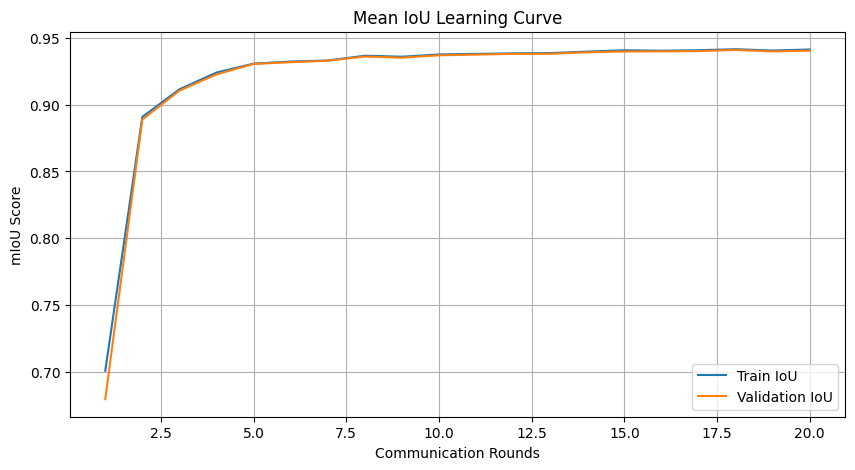

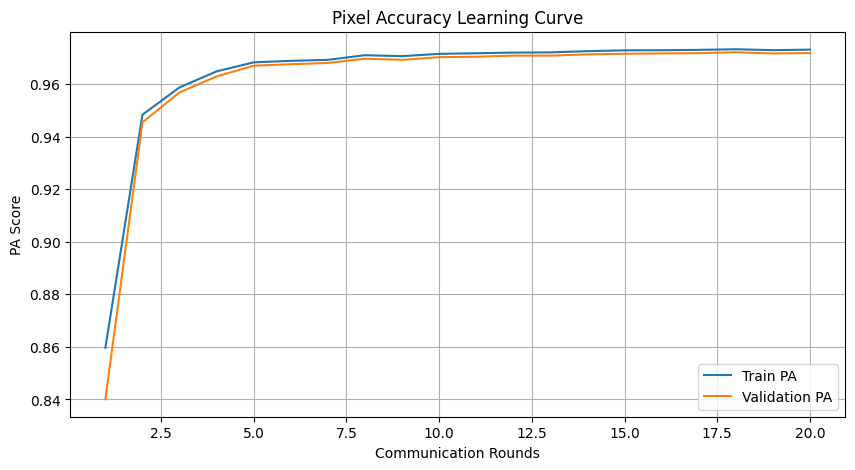

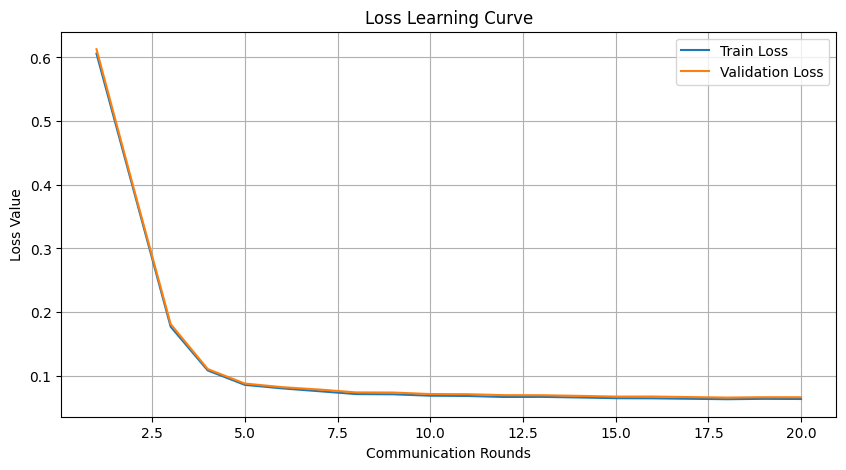

In [47]:
class Plot():
        def __init__(self, res):
            self.res = res
            self.visualize(metric="train_iou", val_metric="val_iou", 
                          label="Train IoU", val_label="Validation IoU", 
                          title="Mean IoU Learning Curve", ylabel="mIoU Score")
            self.visualize(metric="train_pa", val_metric="val_pa", 
                          label="Train PA", val_label="Validation PA", 
                          title="Pixel Accuracy Learning Curve", ylabel="PA Score")
            self.visualize(metric="train_loss", val_metric="val_loss", 
                          label="Train Loss", val_label="Validation Loss", 
                          title="Loss Learning Curve", ylabel="Loss Value")
            
        def plot(self, x, y, label): plt.plot(x, y, label=label)
        
        def decorate(self, xlabel, ylabel, title): 
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)
            plt.show()
            
        def visualize(self, metric, val_metric, label, val_label, title, ylabel):
            plt.figure(figsize=(10, 5))
            self.plot(history['round'], history[metric], label)
            self.plot(history['round'], history[val_metric], val_label)
            self.decorate("Communication Rounds", ylabel, title)                
            
Plot(history)
    

In [49]:
_, test_dl = client_dataloaders[0]  # Using first client's validation as test

<ipython-input-50-1839fa134621>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("saved_models/federated_lung_best_model.pt", map_location=device)


Model loaded successfully!


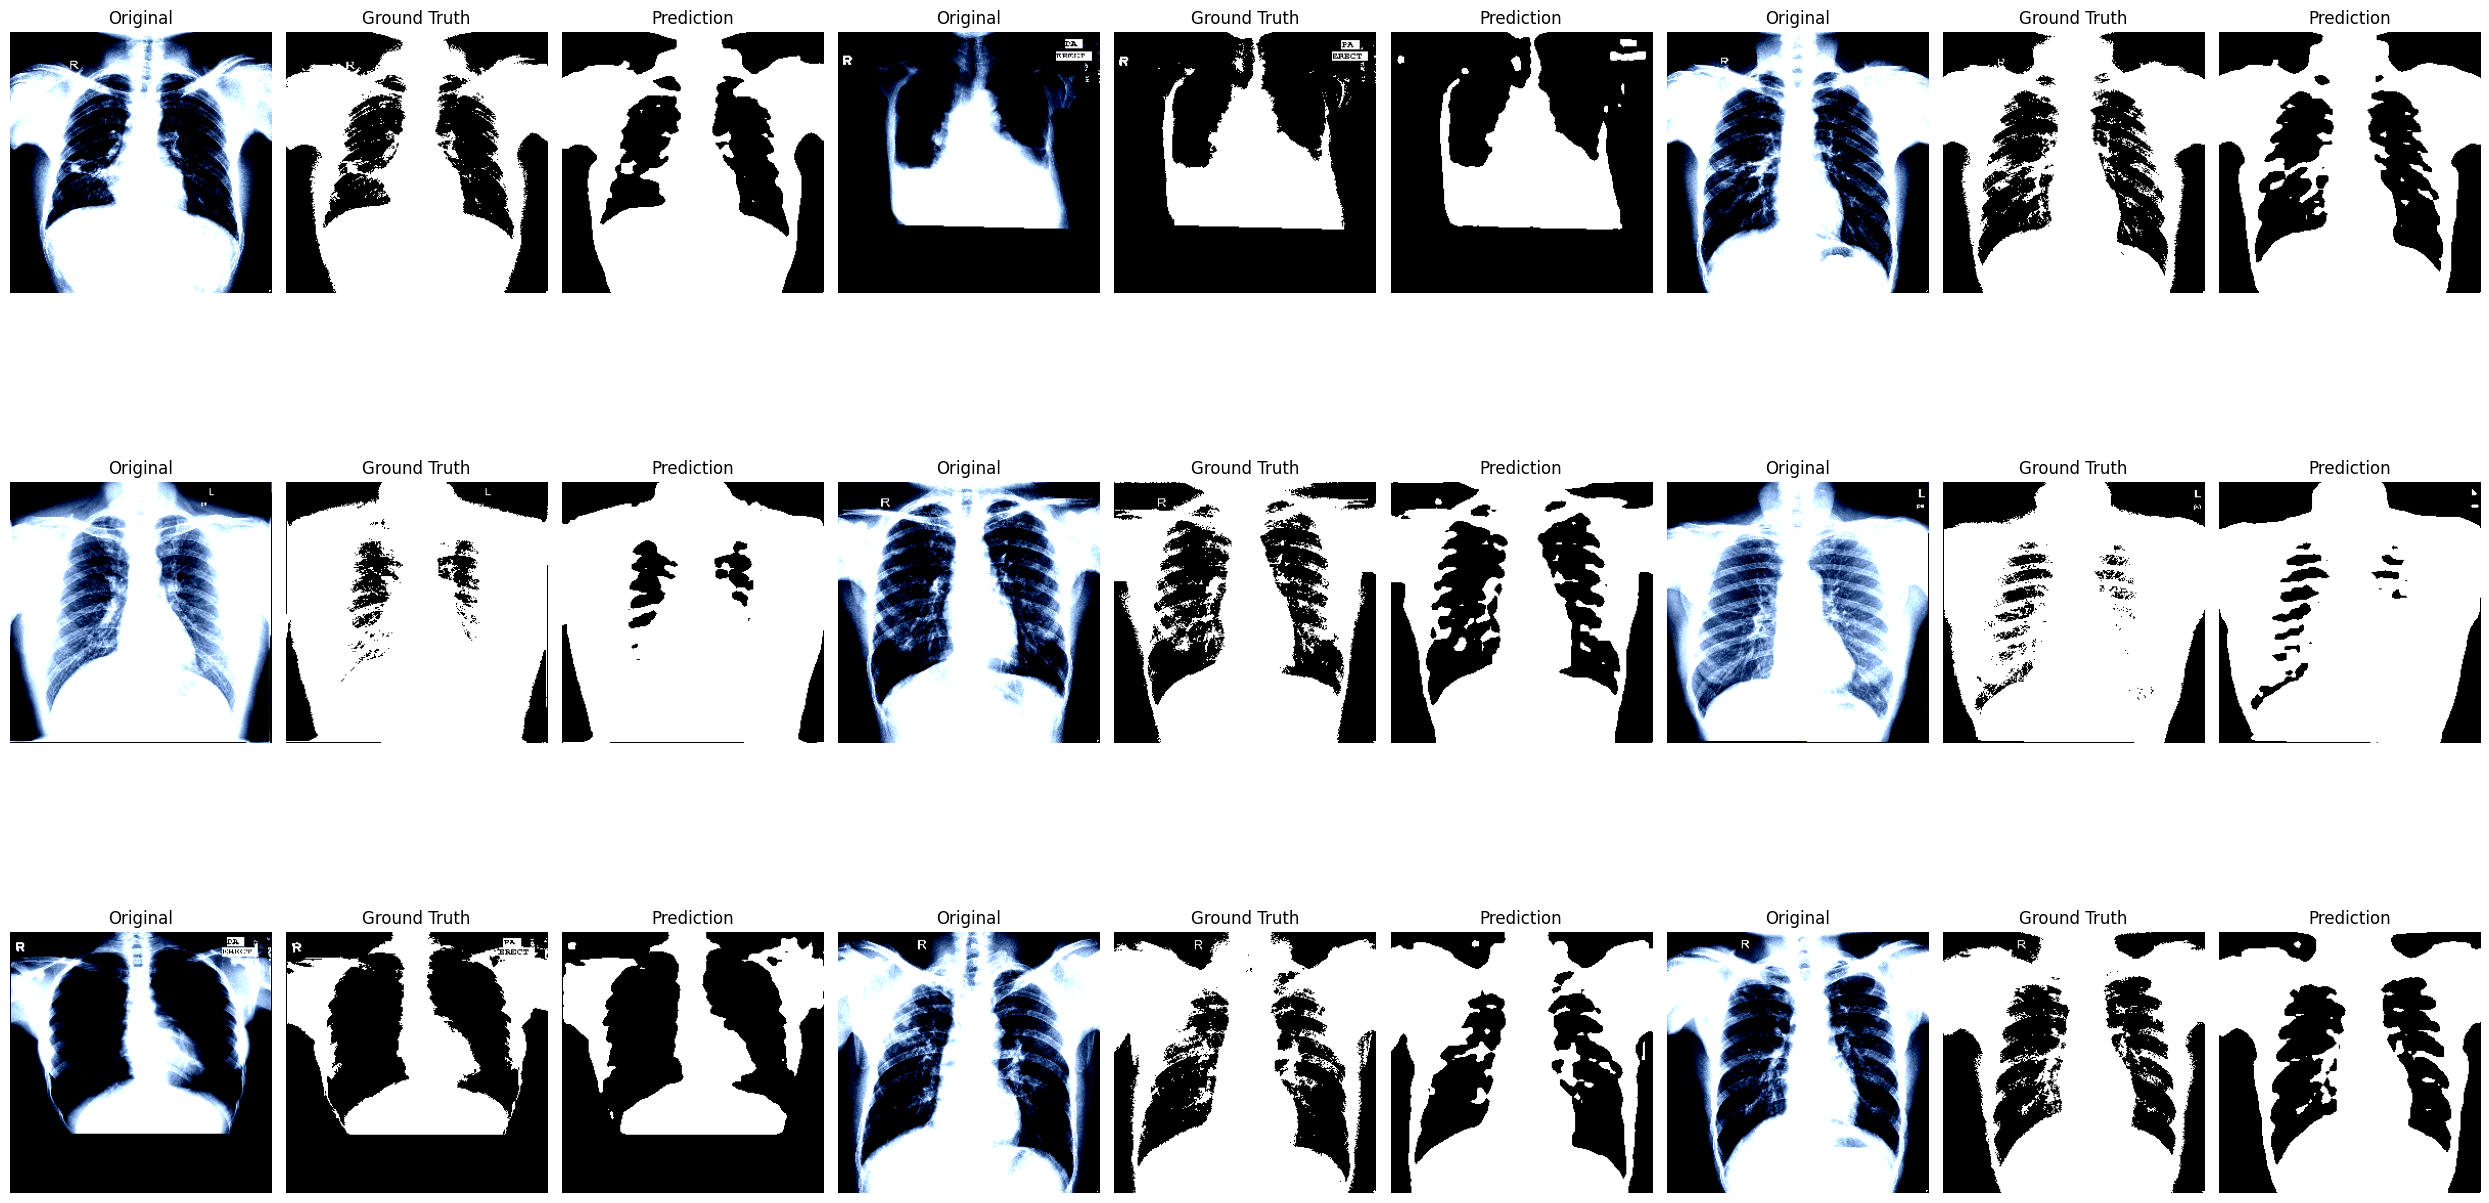

In [ ]:


def inference(dl, model, device, n_ims=9):
    """Optimized inference utilizing GPU properly."""
    model.eval()
    
    cols = 3  # 3 images per row: Original, Ground Truth, Prediction
    n_samples = min(n_ims, len(dl.dataset))  # Ensure we don't exceed dataset size
    rows = (n_samples + cols - 1) // cols  # Compute required rows properly

    fig, axes = plt.subplots(rows, cols * 3, figsize=(25, 5 * rows))
    axes = axes.flatten()  # Flatten the 2D array to access in a loop

    with torch.no_grad():
        img_idx = 0
        for ims, gts in dl:
            ims = ims.to(device)
            preds = torch.argmax(model(ims), dim=1)

            ims = ims.cpu().numpy()
            preds = preds.cpu().numpy()
            gts = gts.cpu().numpy()

            for j in range(ims.shape[0]):  # Iterate over batch images
                if img_idx >= n_samples:
                    break  # Stop when required images are plotted

                im_disp = np.transpose(ims[j], (1, 2, 0)) if ims[j].shape[0] in [1, 3] else ims[j]
                im_disp = np.clip(im_disp, 0, 1) * 255
                im_disp = im_disp.astype(np.uint8)

                axes[img_idx * 3].imshow(im_disp, cmap='gray')
                axes[img_idx * 3].axis('off')
                axes[img_idx * 3].set_title("Original")

                axes[img_idx * 3 + 1].imshow(gts[j].squeeze(), cmap='gray')
                axes[img_idx * 3 + 1].axis('off')
                axes[img_idx * 3 + 1].set_title("Ground Truth")

                axes[img_idx * 3 + 2].imshow(preds[j].squeeze(), cmap='gray')
                axes[img_idx * 3 + 2].axis('off')
                axes[img_idx * 3 + 2].set_title("Prediction")

                img_idx += 1  # Move to next set

            if img_idx >= n_samples:
                break  # Stop after reaching required images

    plt.tight_layout()
    plt.show()

# Load model with GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    model = torch.load("saved_models/federated_lung_best_model.pt", map_location=device)
    model = model.to(device)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

# Run inference only if model loaded
if 'model' in locals():
    inference(test_dl, model=model, device=device)
else:
    print("Cannot run inference - model not loaded")
